In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from pprint import pprint
%matplotlib inline

In [2]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras import metrics
from keras import regularizers

Using TensorFlow backend.


In [4]:
start = datetime(2000,1,1)
end = datetime(2017,1,1)
ticker = 'AMGN'
max_shift = 30
return_shift_days = -5

In [5]:
original_data = pdr.get_data_yahoo(ticker, start, end)
original_data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [6]:
def to_datetime(x):
    return np.array(x, dtype=np.datetime64)

p1 = figure(x_axis_type="datetime", title="{} Closing Prices".format(ticker))
p1.grid.grid_line_alpha=0.3
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = 'Price'

p1.line(to_datetime(original_data.index), original_data['Close'], legend=ticker)
show(p1)

In [7]:
# original_data.to_pickle('SPY.pkl')

In [8]:
# original_data = pd.read_pickle('SPY.pkl')

In [9]:
original_data.head()

,Open,High,Low,Close
Date,,,,
1999-12-31,65.3750,65.5000,59.8750,60.0625
2000-01-03,70.0000,70.0000,62.8750,62.9375
2000-01-04,62.0000,64.1250,57.6875,58.1250
2000-01-05,59.1875,60.6875,58.2500,60.1250
2000-01-06,60.7500,61.9375,60.2500,61.1250


### Create data representation

In [10]:
data = original_data.copy()
data.columns = pd.MultiIndex.from_product([['Shift 0'],['Open','High','Low','Close']])
for i in range(1, max_shift + 1):
    shifted = data.iloc[:,[0,1,2,3]].shift(i)
    shifted.columns = pd.MultiIndex.from_product([['Shift ' + str(i)],['Open','High','Low','Close']])
    data = pd.concat([data, shifted], axis=1)

In [11]:
data.head(6)

Shift 0                             Shift 1                    \
               Open     High      Low    Close     Open     High      Low   
Date                                                                        
1999-12-31  65.3750  65.5000  59.8750  60.0625      NaN      NaN      NaN   
2000-01-03  70.0000  70.0000  62.8750  62.9375  65.3750  65.5000  59.8750   
2000-01-04  62.0000  64.1250  57.6875  58.1250  70.0000  70.0000  62.8750   
2000-01-05  59.1875  60.6875  58.2500  60.1250  62.0000  64.1250  57.6875   
2000-01-06  60.7500  61.9375  60.2500  61.1250  59.1875  60.6875  58.2500   
2000-01-07  62.7500  68.5000  62.6250  68.0000  60.7500  61.9375  60.2500   

                     Shift 2           ...  Shift 28       Shift 29           \
              Close     Open     High  ...       Low Close     Open High Low   
Date                                   ...                                     
1999-12-31      NaN      NaN      NaN  ...       NaN   NaN      NaN  NaN NaN   
2000-01-03  60.0625      NaN      NaN  ...       NaN   NaN      NaN  NaN NaN   
2000-01-04  62.9375  65.3750  65.5000  ...       NaN   NaN      NaN  NaN NaN   
2000-01-05  58.1250  70.0000  70.0000  ...       NaN   NaN      NaN  NaN NaN   
2000-01-06  60.1250  62.0000  64.1250  ...       NaN   NaN      NaN  NaN NaN   
2000-01-07  61.1250  59.1875  60.6875  ...       NaN   NaN      NaN  NaN NaN   

                 Shift 30                 
           Close     Open High Low Close  
Date                                      
1999-12-31   NaN      NaN  NaN NaN   NaN  
2000-01-03   NaN      NaN  NaN NaN   NaN  
2000-01-04   NaN      NaN  NaN NaN   NaN  
2000-01-05   NaN      NaN  NaN NaN   NaN  
2000-01-06   NaN      NaN  NaN NaN   NaN  
2000-01-07   NaN      NaN  NaN NaN   NaN  

[6 rows x 124 columns]

In [12]:
data['Shift 2', 'Close'].head(3)

Date
1999-12-31        NaN
2000-01-03        NaN
2000-01-04    60.0625
Name: (Shift 2, Close), dtype: float64

In [13]:
for i in range(0, max_shift):
    cls = data['Shift ' + str(i), 'Close']
    opn = data['Shift ' + str(i), 'Open']
    data['Shift ' + str(i), 'Bull ' + str(i)] = 100 * (cls - opn) / cls

In [14]:
data['Shift 0'].head(2)

,Open,High,Low,Close,Bull 0
Date,,,,,
1999-12-31,65.375,65.5,59.875,60.0625,-8.844953
2000-01-03,70.000,70.0,62.875,62.9375,-11.221450


In [15]:
for i in range(0, max_shift):
    opn = data['Shift ' + str(i), 'Open']
    prv_cls = data['Shift ' + str(i+1), 'Close']
    data['Shift ' + str(i), 'GT ' + str(i)] = 100 * (opn - prv_cls) / opn

In [16]:
data[['Shift 0', 'Shift 1']].head()

Shift 0                                                   Shift 1  \
               Open     High      Low    Close     Bull 0       GT 0     Open   
Date                                                                            
1999-12-31  65.3750  65.5000  59.8750  60.0625  -8.844953        NaN      NaN   
2000-01-03  70.0000  70.0000  62.8750  62.9375 -11.221450  14.196429  65.3750   
2000-01-04  62.0000  64.1250  57.6875  58.1250  -6.666667  -1.512097  70.0000   
2000-01-05  59.1875  60.6875  58.2500  60.1250   1.559252   1.795143  62.0000   
2000-01-06  60.7500  61.9375  60.2500  61.1250   0.613497   1.028807  59.1875   

                                                             
               High      Low    Close     Bull 1       GT 1  
Date                                                         
1999-12-31      NaN      NaN      NaN        NaN        NaN  
2000-01-03  65.5000  59.8750  60.0625  -8.844953        NaN  
2000-01-04  70.0000  62.8750  62.9375 -11.221450  14.196429  
2000-01-05  64.1250  57.6875  58.1250  -6.666667  -1.512097  
2000-01-06  60.6875  58.2500  60.1250   1.559252   1.795143

In [17]:
shifted = data.iloc[:,[0,1,2,3]].shift(return_shift_days)
shifted.columns = pd.MultiIndex.from_product([['Shift -5'],['Open','High','Low','Close']])
data = pd.concat([data, shifted], axis=1)

In [18]:
cls_5 = data['Shift -5', 'Close']
cls = data['Shift 0', 'Close']
data['Shift 0', 'Return'] = 100 * (cls_5 - cls) / cls_5
data.head()

Shift 0                             Shift 1                    \
               Open     High      Low    Close     Open     High      Low   
Date                                                                        
1999-12-31  65.3750  65.5000  59.8750  60.0625      NaN      NaN      NaN   
2000-01-03  70.0000  70.0000  62.8750  62.9375  65.3750  65.5000  59.8750   
2000-01-04  62.0000  64.1250  57.6875  58.1250  70.0000  70.0000  62.8750   
2000-01-05  59.1875  60.6875  58.2500  60.1250  62.0000  64.1250  57.6875   
2000-01-06  60.7500  61.9375  60.2500  61.1250  59.1875  60.6875  58.2500   

                    Shift 2            ...     Shift 25 Shift 26 Shift 27  \
              Close    Open    High    ...        GT 25    GT 26    GT 27   
Date                                   ...                                  
1999-12-31      NaN     NaN     NaN    ...          NaN      NaN      NaN   
2000-01-03  60.0625     NaN     NaN    ...          NaN      NaN      NaN   
2000-01-04  62.9375  65.375  65.500    ...          NaN      NaN      NaN   
2000-01-05  58.1250  70.000  70.000    ...          NaN      NaN      NaN   
2000-01-06  60.1250  62.000  64.125    ...          NaN      NaN      NaN   

           Shift 28 Shift 29 Shift -5                               Shift 0  
              GT 28    GT 29     Open     High      Low    Close     Return  
Date                                                                         
1999-12-31      NaN      NaN  62.7500  68.5000  62.6250  68.0000  11.672794  
2000-01-03      NaN      NaN  69.5000  72.6875  69.5000  72.1250  12.738302  
2000-01-04      NaN      NaN  72.0625  72.3750  64.1250  66.4375  12.511759  
2000-01-05      NaN      NaN  67.6250  67.7500  62.5625  63.5625   5.408063  
2000-01-06      NaN      NaN  64.7500  67.7500  63.8125  66.8125   8.512629  

[5 rows x 189 columns]

In [19]:
binary_data = data.drop(['Open', 'High', 'Low', 'Close'], axis=1, level=1)
binary_data.head()

,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 6,Shift 7,Shift 8,Shift 9,...,Shift 21,Shift 22,Shift 23,Shift 24,Shift 25,Shift 26,Shift 27,Shift 28,Shift 29,Shift 0
,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 21,GT 22,GT 23,GT 24,GT 25,GT 26,GT 27,GT 28,GT 29,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,-8.844953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.672794
2000-01-03,-11.221450,-8.844953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.738302
2000-01-04,-6.666667,-11.221450,-8.844953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.511759
2000-01-05,1.559252,-6.666667,-11.221450,-8.844953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408063
2000-01-06,0.613497,1.559252,-6.666667,-11.221450,-8.844953,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.512629


In [20]:
binary_data.columns = binary_data.columns.droplevel()

In [21]:
binary_data.head(10)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,Bull 6,Bull 7,Bull 8,Bull 9,...,GT 21,GT 22,GT 23,GT 24,GT 25,GT 26,GT 27,GT 28,GT 29,Return
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,-8.844953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.672794
2000-01-03,-11.221450,-8.844953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.738302
2000-01-04,-6.666667,-11.221450,-8.844953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.511759
2000-01-05,1.559252,-6.666667,-11.221450,-8.844953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408063
2000-01-06,0.613497,1.559252,-6.666667,-11.221450,-8.844953,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.512629
2000-01-07,7.720588,0.613497,1.559252,-6.666667,-11.221450,-8.844953,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.457457
2000-01-10,3.639515,7.720588,0.613497,1.559252,-6.666667,-11.221450,-8.844953,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.434389
2000-01-11,-8.466604,3.639515,7.720588,0.613497,1.559252,-6.666667,-11.221450,-8.844953,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.725694
2000-01-12,-6.391347,-8.466604,3.639515,7.720588,0.613497,1.559252,-6.666667,-11.221450,-8.844953,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.488251


# Train Keras NN

### Setup X_train, X_test, etc

In [22]:
binary_data.dropna(inplace=True)

In [23]:
X = binary_data.drop('Return', axis=1)
y = binary_data['Return'] > 0
y = np.expand_dims(y, axis=1)
y = np.hstack((y, 1 - y))

In [24]:
returns = binary_data['Return']
returns.head(10)

Date
2000-02-14     3.611111
2000-02-15     8.923885
2000-02-16     3.703704
2000-02-17     1.104503
2000-02-18    -4.200913
2000-02-22     1.008249
2000-02-23    -9.798271
2000-02-24   -11.100478
2000-02-25   -10.933082
2000-02-28    -6.001936
Name: Return, dtype: float64

In [25]:
y[0:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
print('Full data size: ', binary_data.shape[0], ' rows')
print('Train data size: ', X_train.shape[0], ' rows')

Full data size:  4243  rows
Train data size:  3394  rows


### Build model

In [29]:
model = Sequential()
model.add(Dense(max_shift*5, input_dim=X.shape[1], kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(max_shift*5, kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2, kernel_initializer='uniform'))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, 
          batch_size=256, 
          verbose=2)

Train on 3394 samples, validate on 849 samples
Epoch 1/500
3s - loss: 0.7210 - acc: 0.4912 - val_loss: 0.6926 - val_acc: 0.5300
Epoch 2/500
0s - loss: 0.7088 - acc: 0.4982 - val_loss: 0.6927 - val_acc: 0.5300
Epoch 3/500
0s - loss: 0.7021 - acc: 0.5130 - val_loss: 0.6927 - val_acc: 0.5300
Epoch 4/500
0s - loss: 0.7040 - acc: 0.5006 - val_loss: 0.6924 - val_acc: 0.5300
Epoch 5/500
0s - loss: 0.6984 - acc: 0.5127 - val_loss: 0.6929 - val_acc: 0.5300
Epoch 6/500
0s - loss: 0.7005 - acc: 0.4918 - val_loss: 0.6924 - val_acc: 0.5300
Epoch 7/500
0s - loss: 0.6943 - acc: 0.5144 - val_loss: 0.6919 - val_acc: 0.5300
Epoch 8/500
0s - loss: 0.6971 - acc: 0.5012 - val_loss: 0.6921 - val_acc: 0.5300
Epoch 9/500
0s - loss: 0.6927 - acc: 0.5168 - val_loss: 0.6917 - val_acc: 0.5300
Epoch 10/500
0s - loss: 0.6927 - acc: 0.5218 - val_loss: 0.6920 - val_acc: 0.5300
Epoch 11/500
0s - loss: 0.6958 - acc: 0.4991 - val_loss: 0.6923 - val_acc: 0.5300
Epoch 12/500
0s - loss: 0.6930 - acc: 0.5162 - val_loss: 0.6

0s - loss: 0.4781 - acc: 0.7814 - val_loss: 0.8713 - val_acc: 0.5289
Epoch 102/500
0s - loss: 0.4780 - acc: 0.7731 - val_loss: 0.8706 - val_acc: 0.5241
Epoch 103/500
0s - loss: 0.4713 - acc: 0.7802 - val_loss: 0.8770 - val_acc: 0.5312
Epoch 104/500
0s - loss: 0.4789 - acc: 0.7775 - val_loss: 0.8652 - val_acc: 0.5265
Epoch 105/500
0s - loss: 0.4732 - acc: 0.7767 - val_loss: 0.8689 - val_acc: 0.5241
Epoch 106/500
0s - loss: 0.4654 - acc: 0.7887 - val_loss: 0.8798 - val_acc: 0.5230
Epoch 107/500
0s - loss: 0.4773 - acc: 0.7796 - val_loss: 0.8608 - val_acc: 0.5289
Epoch 108/500
0s - loss: 0.4589 - acc: 0.7882 - val_loss: 0.8657 - val_acc: 0.5289
Epoch 109/500
0s - loss: 0.4705 - acc: 0.7808 - val_loss: 0.8633 - val_acc: 0.5218
Epoch 110/500
0s - loss: 0.4792 - acc: 0.7775 - val_loss: 0.8677 - val_acc: 0.5112
Epoch 111/500
0s - loss: 0.4625 - acc: 0.7914 - val_loss: 0.8779 - val_acc: 0.5124
Epoch 112/500
0s - loss: 0.4617 - acc: 0.7864 - val_loss: 0.8834 - val_acc: 0.5041
Epoch 113/500
0s -

0s - loss: 0.3553 - acc: 0.8491 - val_loss: 1.0799 - val_acc: 0.5006
Epoch 201/500
0s - loss: 0.3630 - acc: 0.8480 - val_loss: 1.0630 - val_acc: 0.5041
Epoch 202/500
0s - loss: 0.3494 - acc: 0.8524 - val_loss: 1.0985 - val_acc: 0.5077
Epoch 203/500
0s - loss: 0.3476 - acc: 0.8527 - val_loss: 1.0982 - val_acc: 0.5100
Epoch 204/500
0s - loss: 0.3588 - acc: 0.8435 - val_loss: 1.0760 - val_acc: 0.5041
Epoch 205/500
0s - loss: 0.3749 - acc: 0.8412 - val_loss: 1.0558 - val_acc: 0.5041
Epoch 206/500
0s - loss: 0.3487 - acc: 0.8471 - val_loss: 1.0702 - val_acc: 0.5018
Epoch 207/500
0s - loss: 0.3377 - acc: 0.8592 - val_loss: 1.1182 - val_acc: 0.4994
Epoch 208/500
0s - loss: 0.3314 - acc: 0.8586 - val_loss: 1.1181 - val_acc: 0.5088
Epoch 209/500
0s - loss: 0.3535 - acc: 0.8544 - val_loss: 1.0778 - val_acc: 0.5041
Epoch 210/500
0s - loss: 0.3414 - acc: 0.8571 - val_loss: 1.0786 - val_acc: 0.5018
Epoch 211/500
0s - loss: 0.3661 - acc: 0.8412 - val_loss: 1.0579 - val_acc: 0.5006
Epoch 212/500
0s -

0s - loss: 0.2939 - acc: 0.8774 - val_loss: 1.2407 - val_acc: 0.5100
Epoch 300/500
0s - loss: 0.2908 - acc: 0.8786 - val_loss: 1.2956 - val_acc: 0.5053
Epoch 301/500
0s - loss: 0.2986 - acc: 0.8786 - val_loss: 1.2538 - val_acc: 0.4947
Epoch 302/500
0s - loss: 0.2945 - acc: 0.8816 - val_loss: 1.2316 - val_acc: 0.4971
Epoch 303/500
0s - loss: 0.2783 - acc: 0.8872 - val_loss: 1.2501 - val_acc: 0.4994
Epoch 304/500
0s - loss: 0.2790 - acc: 0.8901 - val_loss: 1.2627 - val_acc: 0.4888
Epoch 305/500
0s - loss: 0.2882 - acc: 0.8807 - val_loss: 1.2511 - val_acc: 0.4947
Epoch 306/500
0s - loss: 0.2919 - acc: 0.8848 - val_loss: 1.2604 - val_acc: 0.4829
Epoch 307/500
0s - loss: 0.2991 - acc: 0.8768 - val_loss: 1.1944 - val_acc: 0.4888
Epoch 308/500
0s - loss: 0.3044 - acc: 0.8792 - val_loss: 1.1787 - val_acc: 0.4900
Epoch 309/500
0s - loss: 0.2914 - acc: 0.8795 - val_loss: 1.2228 - val_acc: 0.4947
Epoch 310/500
0s - loss: 0.2973 - acc: 0.8765 - val_loss: 1.2150 - val_acc: 0.5018
Epoch 311/500
0s -

0s - loss: 0.2710 - acc: 0.8910 - val_loss: 1.2859 - val_acc: 0.5018
Epoch 399/500
0s - loss: 0.2417 - acc: 0.9107 - val_loss: 1.3297 - val_acc: 0.4982
Epoch 400/500
0s - loss: 0.2798 - acc: 0.8845 - val_loss: 1.3100 - val_acc: 0.5029
Epoch 401/500
0s - loss: 0.2566 - acc: 0.8995 - val_loss: 1.2782 - val_acc: 0.5124
Epoch 402/500
0s - loss: 0.2762 - acc: 0.8883 - val_loss: 1.2803 - val_acc: 0.5206
Epoch 403/500
0s - loss: 0.2760 - acc: 0.8939 - val_loss: 1.2839 - val_acc: 0.5135
Epoch 404/500
0s - loss: 0.2663 - acc: 0.8960 - val_loss: 1.2240 - val_acc: 0.5124
Epoch 405/500
0s - loss: 0.2704 - acc: 0.8936 - val_loss: 1.2486 - val_acc: 0.5171
Epoch 406/500
0s - loss: 0.2590 - acc: 0.8939 - val_loss: 1.2690 - val_acc: 0.5171
Epoch 407/500
0s - loss: 0.2681 - acc: 0.8869 - val_loss: 1.2755 - val_acc: 0.5124
Epoch 408/500
0s - loss: 0.2515 - acc: 0.8998 - val_loss: 1.2622 - val_acc: 0.5065
Epoch 409/500
0s - loss: 0.2490 - acc: 0.9001 - val_loss: 1.3257 - val_acc: 0.5135
Epoch 410/500
0s -

0s - loss: 0.2536 - acc: 0.8939 - val_loss: 1.3497 - val_acc: 0.4935
Epoch 498/500
0s - loss: 0.2421 - acc: 0.9060 - val_loss: 1.3456 - val_acc: 0.5006
Epoch 499/500
0s - loss: 0.2526 - acc: 0.8966 - val_loss: 1.3217 - val_acc: 0.4982
Epoch 500/500
0s - loss: 0.2338 - acc: 0.9069 - val_loss: 1.3124 - val_acc: 0.5006


In [31]:
predicted = model.predict(X_test)

In [32]:
model.evaluate(X_test, y_test)

480/849 [===============>..............] - ETA: 0s

[1.3123544026319776, 0.50058892825607415]

In [33]:
predicted[0:3]

array([[ 0.94123214,  0.05876785],
       [ 0.29551801,  0.70448196],
       [ 0.02288271,  0.97711736]], dtype=float32)

### Handle predictions

In [34]:
certainty_percentage = predicted.max(axis=0).max()*0.98
print('Certainty is', certainty_percentage, '%')
predicted_ups = predicted[:,0] > certainty_percentage
predicted_downs = predicted[:,1] > certainty_percentage

real_ups = y_test[:,0] == 1
real_downs = y_test[:,1] == 1

Certainty is 0.979426622391 %


### Visualize returns

In [35]:
test_returns = returns.iloc[X_train.shape[0]:]
print('Test period from {} to {}'.format(test_returns.index[0], test_returns.index[-1]))

Test period from 2013-08-13 00:00:00 to 2016-12-22 00:00:00


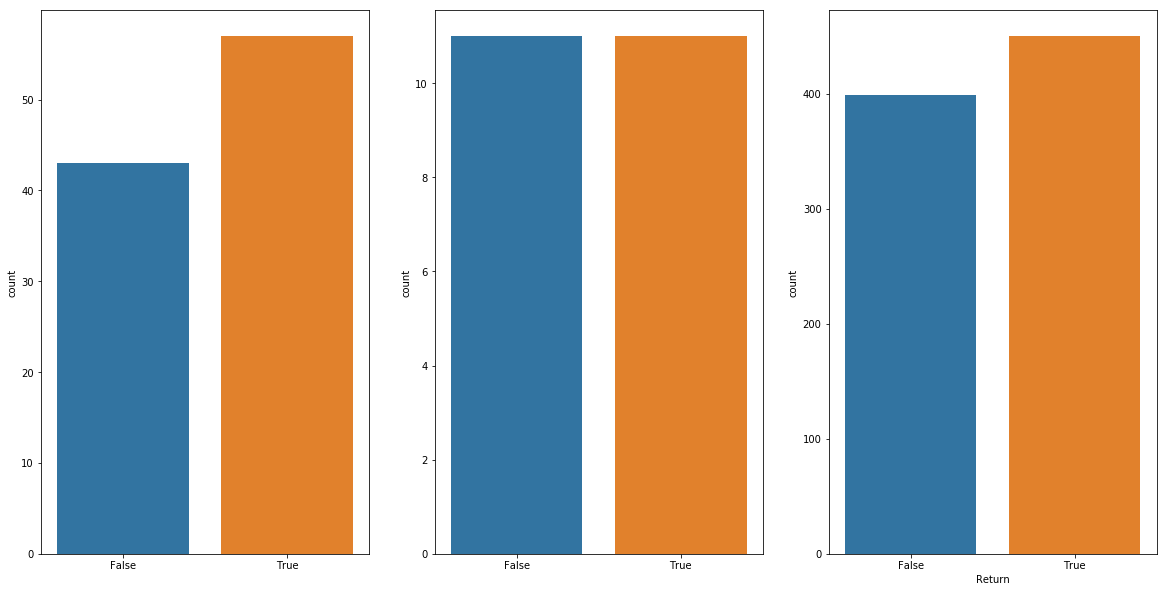

In [36]:
fig, axs = plt.subplots(ncols=3, figsize=(20,10))

if predicted_ups.any():
    sns.countplot(real_ups[predicted_ups], ax=axs[0])
if predicted_downs.any():
    sns.countplot(real_downs[predicted_downs], ax=axs[1])
    
sns.countplot(test_returns > 0, ax=axs[2])

In [37]:
def print_returns_distribution(returns):
    neg = np.sum(returns[returns < 0])
    pos = np.sum(returns[returns > 0])
    print('Negative returns: ', neg)
    print('Positive returns: ', pos)
    print('Pos/Neg ratio: ', pos/(neg*-1))
    print('Sum of returns: ', np.sum(returns))

In [38]:
real_returns = test_returns[predicted_ups].append(-1 * test_returns[predicted_downs])

In [39]:
print_returns_distribution(real_returns)

Negative returns:  -134.0050869200754
Positive returns:  152.30613887943863
Pos/Neg ratio:  1.1365698301459146
Sum of returns:  18.301051959363217


In [40]:
print_returns_distribution(test_returns)

Negative returns:  -1043.7697965680088
Positive returns:  1158.6883195135592
Pos/Neg ratio:  1.1100994906380803
Sum of returns:  114.91852294555014


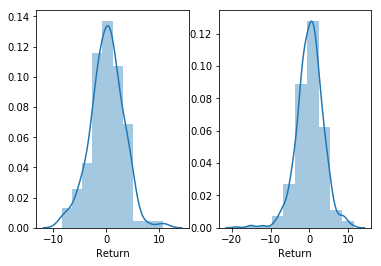

In [41]:
fig, axs = plt.subplots(ncols=2)

sns.distplot(real_returns, bins=10, ax=axs[0])
sns.distplot(test_returns, bins=10, ax=axs[1])